# PPO TRAINING

This script trains PPO agents with various hyperparameter configurations
and tracks performance metrics for comparison with DQN.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All imports successful!")
print(f"Working directory: {os.getcwd()}")

All imports successful!
Working directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training


# PPO HYPERPARAMETER CONFIGURATIONS

Key PPO Hyperparameters:
- learning_rate: Step size for gradient updates
- gamma: Discount factor (same as DQN)
- batch_size: Number of experiences per update (different meaning than DQN)
- n_steps: Steps collected before update (PPO-specific)
- n_epochs: Number of passes through collected data (PPO-specific)
- clip_range: PPO clipping parameter (PPO-specific)
- gae_lambda: GAE parameter for advantage estimation (PPO-specific)
- ent_coef: Entropy coefficient for exploration (PPO-specific)
- vf_coef: Value function coefficient (PPO-specific)

Shared with DQN configs where possible:
- learning_rate, gamma, network architecture


In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: IMPORT CUSTOM ENVIRONMENT
# ═══════════════════════════════════════════════════════════════════════
"""
Import Fire-Rescue environment
"""

import sys
import os

# Add parent directory to path to access sibling folders
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import environment
from environment.custom_env import FireRescueEnv

print("✓ FireRescueEnv imported successfully")

✓ FireRescueEnv imported successfully


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: PPO HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Define all 11 PPO configurations
- Configs 2, 3, 6, 7 mirror DQN configs for direct comparison
- Configs 8, 9, 11 test PPO-specific parameters
- Config 10 is the optimized configuration

FIXED: Increased ent_coef from 0.01 to 0.05 to encourage exploration
       Agent was suffering from action space collapse (only using movement actions)
"""

PPO_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01 for better exploration
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard PPO settings (FIXED exploration)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Matches DQN config 2)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Compare with DQN config 2 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Matches DQN config 3)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Compare with DQN config 3 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 256,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 32,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Matches DQN config 6)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.95,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Compare with DQN config 6 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Matches DQN config 7)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.995,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Compare with DQN config 7"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: HIGH ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_high_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.1,  # High entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Entropy - More exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: LOW ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_low_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.0,  # No entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Entropy - Pure exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 128,
        "n_steps": 4096,  # More steps
        "n_epochs": 15,  # More epochs
        "clip_range": 0.2,
        "gae_lambda": 0.98,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper
        "description": "Optimized - Best guess for task"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: MANY EPOCHS (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_11_many_epochs": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 20,  # Many epochs
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Many Epochs - Sample efficient"
    },
}

# Print configuration summary
print(f"✓ Defined {len(PPO_CONFIGS)} PPO configurations\n")
print("="*110)
print(f"{'Config':<30} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'N_Steps':<10} {'Epochs':<8} {'Ent_Coef':<12} {'Network':<12}")
print("="*110)

for config_name, config in PPO_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<30} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['n_steps']:<10} "
          f"{config['n_epochs']:<8} {config['ent_coef']:<12.2f} {net_arch:<12}")

print("="*110)

✓ Defined 11 PPO configurations

Config                         LR         Gamma    Batch    N_Steps    Epochs   Ent_Coef     Network     
config_1_baseline              3e-04      0.990    64       2048       10       0.05         [64, 64]    
config_2_high_lr               5e-03      0.990    64       2048       10       0.05         [64, 64]    
config_3_low_lr                1e-05      0.990    64       2048       10       0.05         [64, 64]    
config_4_large_batch           3e-04      0.990    256      2048       10       0.05         [64, 64]    
config_5_small_batch           3e-04      0.990    32       2048       10       0.05         [64, 64]    
config_6_low_gamma             3e-04      0.950    64       2048       10       0.05         [64, 64]    
config_7_high_gamma            3e-04      0.995    64       2048       10       0.05         [64, 64]    
config_8_high_entropy          3e-04      0.990    64       2048       10       0.10         [64, 64]    
config_9_low_

In [4]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 4: CUSTOM CALLBACK FOR METRICS TRACKING
# ═══════════════════════════════════════════════════════════════════════
"""
Custom callback to track training metrics in real-time
"""

class MetricsCallback(BaseCallback):
    """
    Tracks episode rewards, lengths, and performs periodic evaluation
    """
    def __init__(self, eval_env, eval_freq=5000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.eval_rewards = []
        self.eval_stds = []
        self.timesteps = []
        
    def _on_step(self):
        # Log episode metrics
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                if 'r' in info:
                    self.episode_rewards.append(info['r'])
                if 'l' in info:
                    self.episode_lengths.append(info['l'])
        
        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            # Evaluate with process metrics
            eval_rewards = []
            n_eval = 10
            
            for _ in range(n_eval):
                obs, _ = self.eval_env.reset()
                done = False
                episode_reward = 0
                
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = self.eval_env.step(action)
                    episode_reward += reward
                    done = terminated or truncated
                
                eval_rewards.append(episode_reward)
            
            mean_reward = np.mean(eval_rewards)
            std_reward = np.std(eval_rewards)
            
            self.eval_rewards.append(mean_reward)
            self.eval_stds.append(std_reward)
            self.timesteps.append(self.num_timesteps)
            
            if self.verbose > 0:
                print(f"  [Eval] Step {self.num_timesteps:>6}: "
                      f"Reward = {mean_reward:>7.2f} ± {std_reward:>5.2f}")
        
        return True

print("✓ MetricsCallback class defined")

✓ MetricsCallback class defined


In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: TRAINING FUNCTION (FIXED)
# ═══════════════════════════════════════════════════════════════════════
"""
Main training function for a single configuration
FIXED: Corrected success rate calculation logic
"""

def train_ppo_config(config_name, config, total_timesteps=100000, save_dir="../models/ppo"):
    """
    Train PPO agent with specified configuration
    
    Args:
        config_name: Name of configuration
        config: Dict of hyperparameters
        total_timesteps: Total training steps
        save_dir: Directory to save models (default: ../models/ppo - one level up from training folder)
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*80}")
    print(f"Training: {config_name}")
    print(f"📝 {config['description']}")
    print(f"{'='*80}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    config_dir = os.path.join(save_dir, config_name)
    os.makedirs(config_dir, exist_ok=True)
    
    # Create environments
    env = FireRescueEnv(grid_size=10, max_time=250)
    eval_env = FireRescueEnv(grid_size=10, max_time=250)
    
    # Extract PPO parameters
    ppo_params = {k: v for k, v in config.items() 
                  if k not in ['description', 'policy_kwargs']}
    ppo_params['policy_kwargs'] = config['policy_kwargs']
    
    # Create model
    print(f"\nCreating PPO model...")
    model = PPO(
        "MlpPolicy",
        env,
        verbose=0,  # Set to 0 for cleaner output
        tensorboard_log=os.path.join(config_dir, "tensorboard"),
        **ppo_params
    )
    
    # Create callback
    callback = MetricsCallback(eval_env, eval_freq=5000, verbose=1)
    
    # Train
    print(f"🎓 Training for {total_timesteps:,} timesteps...\n")
    start_time = datetime.now()
    
    model.learn(
        total_timesteps=total_timesteps,
        callback=callback,
        progress_bar=True
    )
    
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Final evaluation (100 episodes)
    print(f"\nFinal evaluation (100 episodes)...")
    mean_reward, std_reward = evaluate_policy(
        model, 
        eval_env, 
        n_eval_episodes=100,
        deterministic=True
    )
    
    # ═══════════════════════════════════════════════════════════════════════
    # Calculate episode metrics
    # ═══════════════════════════════════════════════════════════════════════
    print(f"Calculating episode performance metrics...")
    episode_rewards = []
    episode_lengths = []
    wall_collision_rates = []
    scan_efficiencies = []
    pickup_attempts_list = []
    time_to_find_survivor_list = []
    
    for episode_num in range(100):
        obs, _ = eval_env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
        
        # Extract metrics from final info
        episode_rewards.append(info.get('episode_length', 0) * -0.01)  # Approximation
        episode_lengths.append(info.get('episode_length', 0))
        wall_collision_rates.append(info.get('wall_collision_rate', 0))
        scan_efficiencies.append(info.get('scan_efficiency', 0))
        pickup_attempts_list.append(info.get('pickup_attempts', 0))
        
        time_found = info.get('time_to_find_survivor', None)
        if time_found is not None:
            time_to_find_survivor_list.append(time_found)
        
        # Debug output for first 5 episodes
        if episode_num < 5:
            print(f"  Episode {episode_num+1}: "
                  f"Steps: {info.get('episode_length', 0)} | "
                  f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                  f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
    
    print(f"\n📊 Evaluation Summary:")
    print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
    print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
    print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
    print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
    if time_to_find_survivor_list:
        print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/100 found)")
    
    # Save model
    model_path = os.path.join(config_dir, "final_model")
    model.save(model_path)
    
    # Save results
    results = {
        "config_name": config_name,
        "config": config,
        "mean_reward": float(mean_reward),
        "std_reward": float(std_reward),
        "avg_episode_length": float(np.mean(episode_lengths)),
        "wall_collision_rate": float(np.mean(wall_collision_rates)),
        "scan_efficiency": float(np.mean(scan_efficiencies)),
        "avg_pickup_attempts": float(np.mean(pickup_attempts_list)),
        "avg_time_to_find_survivor": float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
        "survivor_found_count": len(time_to_find_survivor_list),
        "training_time": training_time,
        "total_timesteps": total_timesteps,
        "eval_timesteps": callback.timesteps,
        "eval_rewards": callback.eval_rewards,
        "eval_stds": callback.eval_stds,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "wall_collision_rates": wall_collision_rates,
        "scan_efficiencies": scan_efficiencies,
        "pickup_attempts": pickup_attempts_list,
        "time_to_find_survivor": time_to_find_survivor_list,
    }
    
    with open(os.path.join(config_dir, "results.json"), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Plot training curve
    if len(callback.timesteps) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(callback.timesteps, callback.eval_rewards, 'b-', linewidth=2, marker='o')
        plt.fill_between(callback.timesteps, 
                         np.array(callback.eval_rewards) - np.array(callback.eval_stds),
                         np.array(callback.eval_rewards) + np.array(callback.eval_stds),
                         alpha=0.3)
        plt.xlabel('Timesteps', fontsize=14)
        plt.ylabel('Mean Reward', fontsize=14)
        plt.title(f'{config_name}\nReward: {mean_reward:.2f} ± {std_reward:.2f} | Avg Steps: {np.mean(episode_lengths):.1f} | Wall Collisions: {np.mean(wall_collision_rates):.1%}', 
                  fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(config_dir, "training_curve.png"), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"RESULTS for {config_name}:")
    print(f"   Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"   Avg Episode Length: {np.mean(episode_lengths):.1f} steps")
    print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
    print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
    print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
    if time_to_find_survivor_list:
        print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps")
    print(f"   Training Time: {training_time:.1f}s ({training_time/60:.1f} min)")
    print(f"   Saved to: {config_dir}")
    print(f"{'='*80}\n")
    
    # Cleanup
    env.close()
    eval_env.close()
    
    return results

print("✓ Training function defined (FIXED)")

✓ Training function defined (FIXED)



PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT

Total Configs: 11
Timesteps per config: 100,000
Total training timesteps: 1,100,000

This will take approximately 22.0 hours
    (Estimate: ~10 min per config)



Progress: 1/11 configurations

Training: config_1_baseline
📝 Baseline - Standard PPO settings (FIXED exploration)

Creating PPO model...
🎓 Training for 100,000 timesteps...

🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -68.99 ± 96.10

[Eval] Step  10000: Reward =  -54.92 ± 118.27

[Eval] Step  15000: Reward =  -88.97 ± 83.23

[Eval] Step  20000: Reward =  -43.82 ± 78.07

[Eval] Step  25000: Reward =  -73.55 ± 60.46

[Eval] Step  30000: Reward =  -25.11 ± 62.51

[Eval] Step  35000: Reward =   -6.12 ± 50.08

[Eval] Step  40000: Reward =  -56.52 ± 98.20

[Eval] Step  45000: Reward =  -66.76 ± 107.68

[Eval] Step  50000: Reward =  -80.08 ± 105.46

[Eval] Step  55000: Reward =  -98.93 ± 124.52

[Eval] Step  60000: Reward =  -25.50 ± 94.26

[Eval] Step  65000: Reward = -136.72 ± 115.04

[Eval] Step  70000: Reward = -130.28 ± 60.38

[Eval] Step  75000: Reward = -200.57 ± 35.28

[Eval] Step  80000: Reward = -210.29 ± 52.46

[Eval] Step  85000: Reward = -168.31 ± 38.30

[Eval] Step  90000: Reward = -207.98 ± 34.27

[Eval] Step  95000: Reward = -233.05 ± 26.72

[Eval] Step 100000: Reward = -226.28 ± 24.69


Final evaluation (100 episodes)...
Calculating episode performance metrics...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.78% | Scan Eff: 0.00%
  Episode 1: Steps: 250 | Wall Collisions: 94.78% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 72.55% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 72.55% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 227.0 steps
   Wall Collision Rate: 56.19%
   Scan Efficiency: 6.00%
   Avg Pickup Attempts: 63.00
   Avg Time to Find Survivor: 68.0 steps (31/100 foun

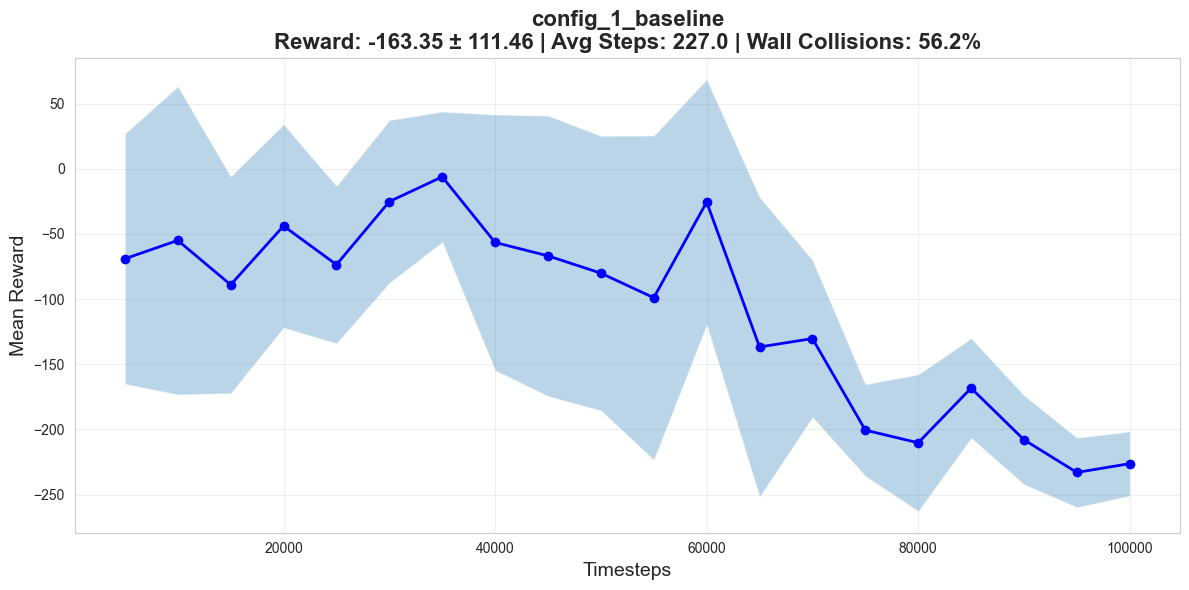


RESULTS for config_1_baseline:
   Mean Reward: -163.35 ± 111.46
   Avg Episode Length: 227.0 steps
   Wall Collision Rate: 56.19%
   Scan Efficiency: 6.00%
   Avg Pickup Attempts: 63.00
   Avg Time to Find Survivor: 68.0 steps
   Training Time: 213.1s (3.6 min)
   Saved to: ../models/ppo\config_1_baseline


Progress: 2/11 configurations

Training: config_2_high_lr
📝 High LR - Compare with DQN config 2 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -62.87 ± 149.11

[Eval] Step  10000: Reward =  -77.77 ± 149.23

[Eval] Step  15000: Reward =  -80.62 ± 86.79

[Eval] Step  20000: Reward =  -71.40 ± 56.39

[Eval] Step  25000: Reward = -100.58 ± 98.80

[Eval] Step  30000: Reward =  -59.70 ± 77.52

[Eval] Step  35000: Reward =  -73.53 ± 96.19

[Eval] Step  40000: Reward =  -46.08 ± 50.53

[Eval] Step  45000: Reward =  -12.95 ± 68.22

[Eval] Step  50000: Reward = -191.64 ± 58.81

[Eval] Step  55000: Reward = -206.15 ± 56.18

[Eval] Step  60000: Reward = -141.18 ± 144.88

[Eval] Step  65000: Reward =  -19.40 ± 140.41

[Eval] Step  70000: Reward =  -34.49 ± 113.32

[Eval] Step  75000: Reward = -144.01 ± 154.91

[Eval] Step  80000: Reward =   32.61 ± 142.40

[Eval] Step  85000: Reward =   20.90 ± 39.78

[Eval] Step  90000: Reward =  -31.27 ± 123.55

[Eval] Step  95000: Reward =   31.07 ± 59.73

[Eval] Step 100000: Reward =  -56.23 ± 133.12


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 73.08% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 73.08% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 64 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 39.58%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 64 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 39.58%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 239.1 steps
   Wall Collision Rate: 6.26%
   Scan Efficiency: 7.13%
   Avg Pickup Attempts: 40.67
   Avg Time to Find Survivor: 123.0 steps (27/100 found)



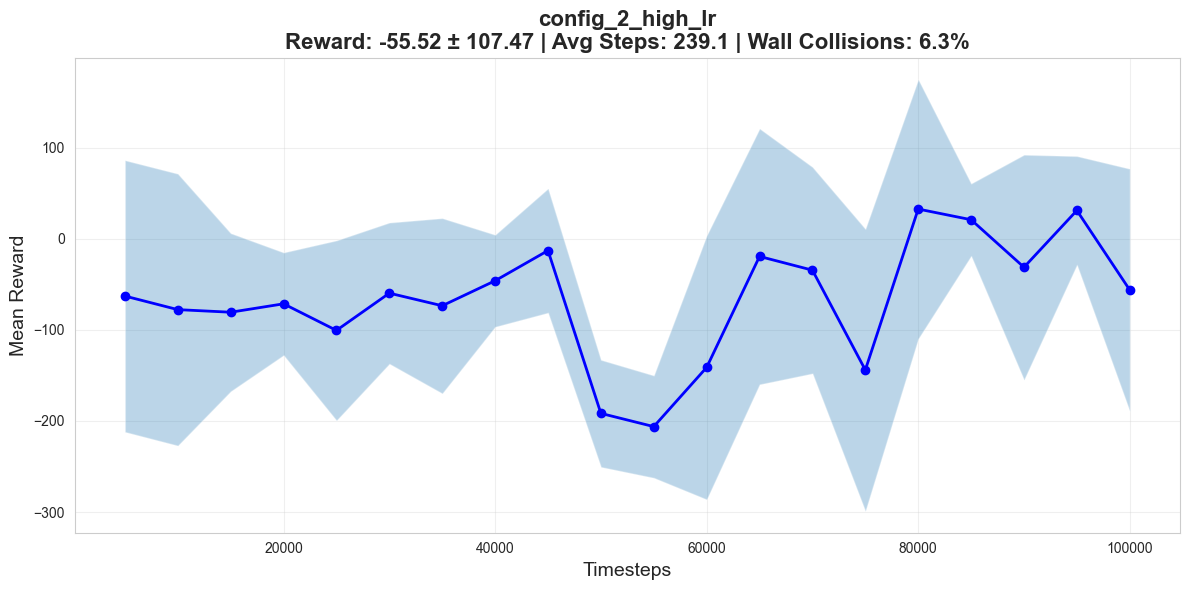


RESULTS for config_2_high_lr:
   Mean Reward: -55.52 ± 107.47
   Avg Episode Length: 239.1 steps
   Wall Collision Rate: 6.26%
   Scan Efficiency: 7.13%
   Avg Pickup Attempts: 40.67
   Avg Time to Find Survivor: 123.0 steps
   Training Time: 223.8s (3.7 min)
   Saved to: ../models/ppo\config_2_high_lr


Progress: 3/11 configurations

Training: config_3_low_lr
📝 Low LR - Compare with DQN config 3 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -225.30 ± 61.32

[Eval] Step  10000: Reward = -190.80 ± 32.62

[Eval] Step  15000: Reward =  -18.06 ± 12.84

[Eval] Step  20000: Reward =    0.06 ±  0.20

[Eval] Step  25000: Reward =  -35.28 ± 30.14

[Eval] Step  30000: Reward = -134.61 ± 35.08

[Eval] Step  35000: Reward =    0.18 ±  0.25

[Eval] Step  40000: Reward =   -7.35 ± 15.44

[Eval] Step  45000: Reward =    0.21 ±  0.19

[Eval] Step  50000: Reward =    0.18 ±  0.21

[Eval] Step  55000: Reward =  -41.46 ± 35.37

[Eval] Step  60000: Reward =    0.15 ±  0.22

[Eval] Step  65000: Reward =  -74.94 ± 37.26

[Eval] Step  70000: Reward =    0.00 ±  0.14

[Eval] Step  75000: Reward = -185.46 ± 53.41

[Eval] Step  80000: Reward = -103.71 ± 57.52

[Eval] Step  85000: Reward =  -61.26 ± 30.89

[Eval] Step  90000: Reward = -106.86 ± 57.78

[Eval] Step  95000: Reward =  -73.08 ± 60.26

[Eval] Step 100000: Reward = -178.23 ± 45.60


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 21.29% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 9.24% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 21.29% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 9.24% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 52.21% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 2.41% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 52.21% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 2.41% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 23.97%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 4.8 steps (13/100 found)



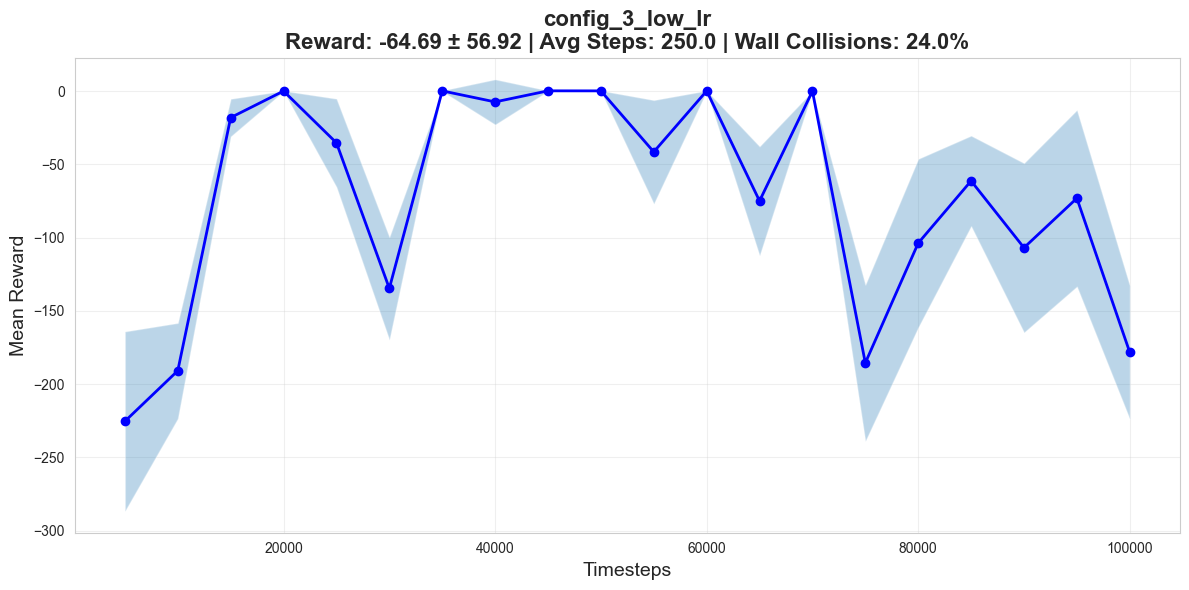


RESULTS for config_3_low_lr:
   Mean Reward: -64.69 ± 56.92
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 23.97%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 4.8 steps
   Training Time: 303.0s (5.1 min)
   Saved to: ../models/ppo\config_3_low_lr


Progress: 4/11 configurations

Training: config_4_large_batch
📝 Large Batch - Stable gradients

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -56.24 ± 37.63

[Eval] Step  10000: Reward =  -21.56 ± 51.30

[Eval] Step  15000: Reward =  -97.65 ± 56.82

[Eval] Step  20000: Reward =  -17.66 ± 13.36

[Eval] Step  25000: Reward =  -13.29 ± 32.39

[Eval] Step  30000: Reward =   -7.56 ± 21.02

[Eval] Step  35000: Reward =    0.69 ±  0.38

[Eval] Step  40000: Reward =  -59.61 ± 87.06

[Eval] Step  45000: Reward =  -48.12 ± 89.85

[Eval] Step  50000: Reward =  -80.79 ± 113.96

[Eval] Step  55000: Reward =  -31.56 ± 75.84

[Eval] Step  60000: Reward = -122.58 ± 115.55

[Eval] Step  65000: Reward =  -56.04 ± 91.96

[Eval] Step  70000: Reward = -133.53 ± 104.49

[Eval] Step  75000: Reward =  -45.34 ± 72.73

[Eval] Step  80000: Reward = -121.05 ± 105.83

[Eval] Step  85000: Reward = -132.27 ± 91.95

[Eval] Step  90000: Reward = -142.39 ± 103.46

[Eval] Step  95000: Reward = -174.59 ± 98.36

[Eval] Step 100000: Reward = -178.51 ± 86.41


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.35% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.35% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 94.06% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.98% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 92.34% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 94.06% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.98% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 92.34% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 89.17%
   Scan Efficiency: 2.00%
   Avg Pickup Attempts: 16.58
   Avg Time to Find Survivor: 9.0 steps (68/100 f

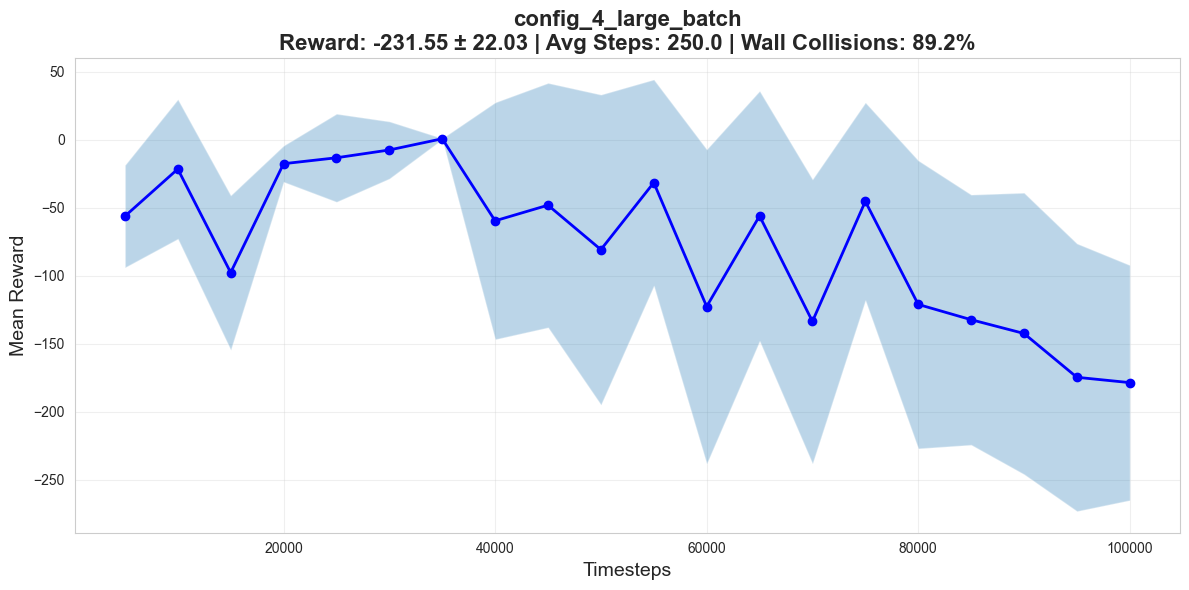


RESULTS for config_4_large_batch:
   Mean Reward: -231.55 ± 22.03
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 89.17%
   Scan Efficiency: 2.00%
   Avg Pickup Attempts: 16.58
   Avg Time to Find Survivor: 9.0 steps
   Training Time: 91.2s (1.5 min)
   Saved to: ../models/ppo\config_4_large_batch


Progress: 5/11 configurations

Training: config_5_small_batch
📝 Small Batch - Fast updates

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -10.48 ± 18.43

[Eval] Step  10000: Reward =    0.59 ± 35.50

[Eval] Step  15000: Reward =  -22.31 ±  3.49

[Eval] Step  20000: Reward =   -4.18 ± 38.70

[Eval] Step  25000: Reward =  -25.13 ±  6.24

[Eval] Step  30000: Reward =  -52.76 ± 54.39

[Eval] Step  35000: Reward =  -52.23 ± 81.30

[Eval] Step  40000: Reward =  -37.34 ± 50.85

[Eval] Step  45000: Reward =  -49.29 ± 100.19

[Eval] Step  50000: Reward =  -20.01 ± 82.80

[Eval] Step  55000: Reward =  -39.01 ± 110.52

[Eval] Step  60000: Reward =    2.90 ± 133.35

[Eval] Step  65000: Reward =  -51.51 ± 154.50

[Eval] Step  70000: Reward = -146.67 ± 133.60

[Eval] Step  75000: Reward = -237.29 ± 14.03

[Eval] Step  80000: Reward = -116.47 ± 141.99

[Eval] Step  85000: Reward =  -71.43 ± 143.13

[Eval] Step  90000: Reward = -223.82 ± 38.28

[Eval] Step  95000: Reward = -182.09 ± 106.39

[Eval] Step 100000: Reward =  -46.31 ± 167.55


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 89.81%
  Episode 2: Steps: 250 | Wall Collisions: 72.50% | Scan Eff: 83.73%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 89.81%
  Episode 2: Steps: 250 | Wall Collisions: 72.50% | Scan Eff: 83.73%
  Episode 3: Steps: 250 | Wall Collisions: 73.58% | Scan Eff: 100.00%
  Episode 4: Steps: 20 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 142 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 73.58% | Scan Eff: 100.00%
  Episode 4: Steps: 20 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 142 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 173.6 steps
   Wall Collision Rate: 41.95%
   Scan Efficiency: 23.55%
   Avg Pickup Attempts: 28.27
   Avg Time to Find Survivor: 41.5 steps (53/100

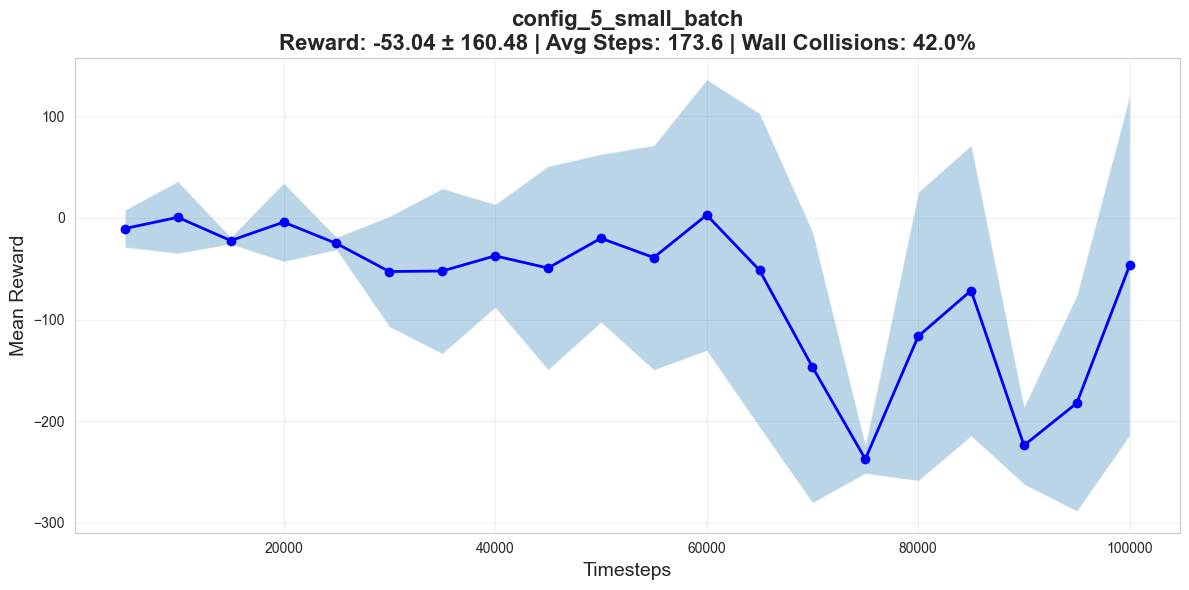


RESULTS for config_5_small_batch:
   Mean Reward: -53.04 ± 160.48
   Avg Episode Length: 173.6 steps
   Wall Collision Rate: 41.95%
   Scan Efficiency: 23.55%
   Avg Pickup Attempts: 28.27
   Avg Time to Find Survivor: 41.5 steps
   Training Time: 308.2s (5.1 min)
   Saved to: ../models/ppo\config_5_small_batch


Progress: 6/11 configurations

Training: config_6_low_gamma
📝 Low Gamma - Compare with DQN config 6 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -20.11 ± 66.95

[Eval] Step  10000: Reward =   -5.36 ± 39.28

[Eval] Step  15000: Reward =   19.47 ± 30.24

[Eval] Step  20000: Reward =  -11.54 ± 39.94

[Eval] Step  25000: Reward =  -34.19 ± 27.46

[Eval] Step  30000: Reward =  -46.69 ± 44.78

[Eval] Step  35000: Reward =   -0.78 ±  4.09

[Eval] Step  40000: Reward =    2.07 ± 50.03

[Eval] Step  45000: Reward =  -21.49 ± 40.25

[Eval] Step  50000: Reward =  -46.12 ± 29.83

[Eval] Step  55000: Reward =    2.27 ± 38.47

[Eval] Step  60000: Reward =  -26.68 ± 41.97

[Eval] Step  65000: Reward =   -7.20 ± 26.79

[Eval] Step  70000: Reward =  -14.57 ± 60.59

[Eval] Step  75000: Reward =  -18.32 ± 96.65

[Eval] Step  80000: Reward =  -94.02 ± 147.28

[Eval] Step  85000: Reward =   39.56 ± 101.81

[Eval] Step  90000: Reward =  -48.42 ± 165.59

[Eval] Step  95000: Reward = -145.58 ± 125.88

[Eval] Step 100000: Reward =  -78.36 ± 139.11


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 92.34% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 80.77% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 250 | Wall Collisions: 92.34% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 80.77% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 218.8 steps
   Wall Collision Rate: 52.11%
   Scan Efficiency: 16.00%
   Avg Pickup Attempts: 35.64
   Avg Time to Find Survivor: 55.7 steps (50/100

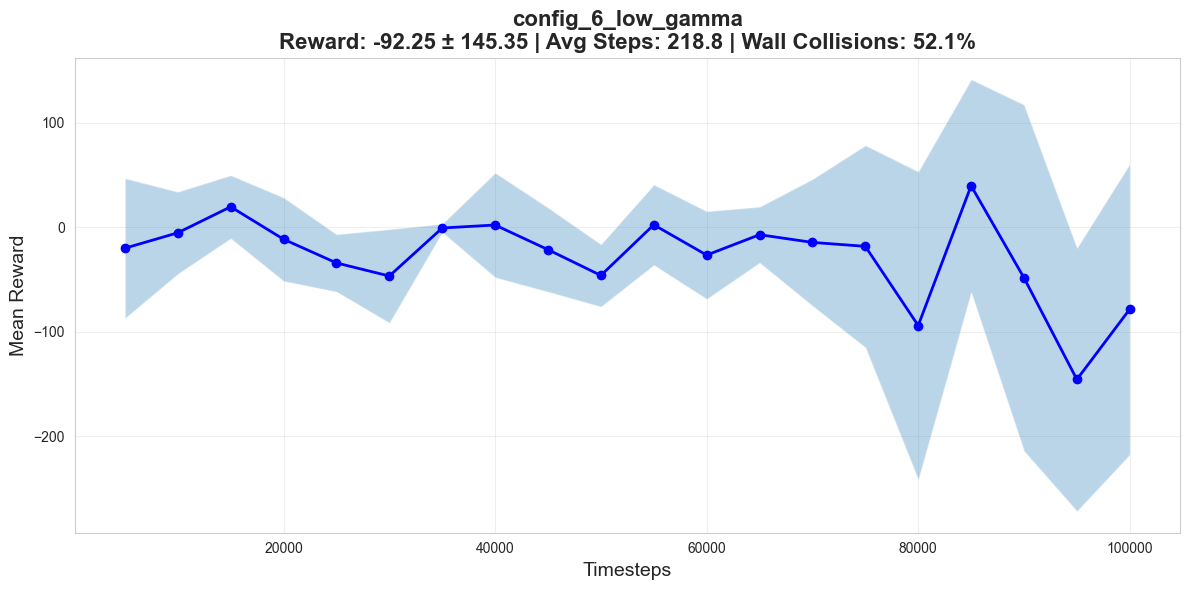


RESULTS for config_6_low_gamma:
   Mean Reward: -92.25 ± 145.35
   Avg Episode Length: 218.8 steps
   Wall Collision Rate: 52.11%
   Scan Efficiency: 16.00%
   Avg Pickup Attempts: 35.64
   Avg Time to Find Survivor: 55.7 steps
   Training Time: 199.6s (3.3 min)
   Saved to: ../models/ppo\config_6_low_gamma


Progress: 7/11 configurations

Training: config_7_high_gamma
📝 High Gamma - Compare with DQN config 7

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -121.56 ± 86.53

[Eval] Step  10000: Reward = -145.11 ± 60.17

[Eval] Step  15000: Reward =   -5.52 ± 14.83

[Eval] Step  20000: Reward =  -61.26 ± 70.59

[Eval] Step  25000: Reward =  -33.79 ± 62.99

[Eval] Step  30000: Reward =  -24.72 ± 22.90

[Eval] Step  35000: Reward =   -4.32 ± 93.88

[Eval] Step  40000: Reward =  -97.60 ± 94.78

[Eval] Step  45000: Reward =  -40.89 ± 75.87

[Eval] Step  50000: Reward =  -69.56 ± 81.61

[Eval] Step  55000: Reward =  -99.05 ± 117.52

[Eval] Step  60000: Reward =  -26.82 ± 72.90

[Eval] Step  65000: Reward = -136.76 ± 137.28

[Eval] Step  70000: Reward =   -0.23 ± 100.51

[Eval] Step  75000: Reward = -148.61 ± 89.29

[Eval] Step  80000: Reward = -160.08 ± 95.22

[Eval] Step  85000: Reward = -230.40 ± 46.69

[Eval] Step  90000: Reward = -229.45 ± 20.01

[Eval] Step  95000: Reward = -174.74 ± 67.39

[Eval] Step 100000: Reward = -189.17 ± 98.52


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 97.78% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 60.08% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 97.78% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 60.08% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 241.8 steps
   Wall Collision Rate: 39.70%
   Scan Efficiency: 7.00%
   Avg Pickup Attempts: 61.11
   Avg Time to Find Survivor: 74.9 steps (26/100 foun

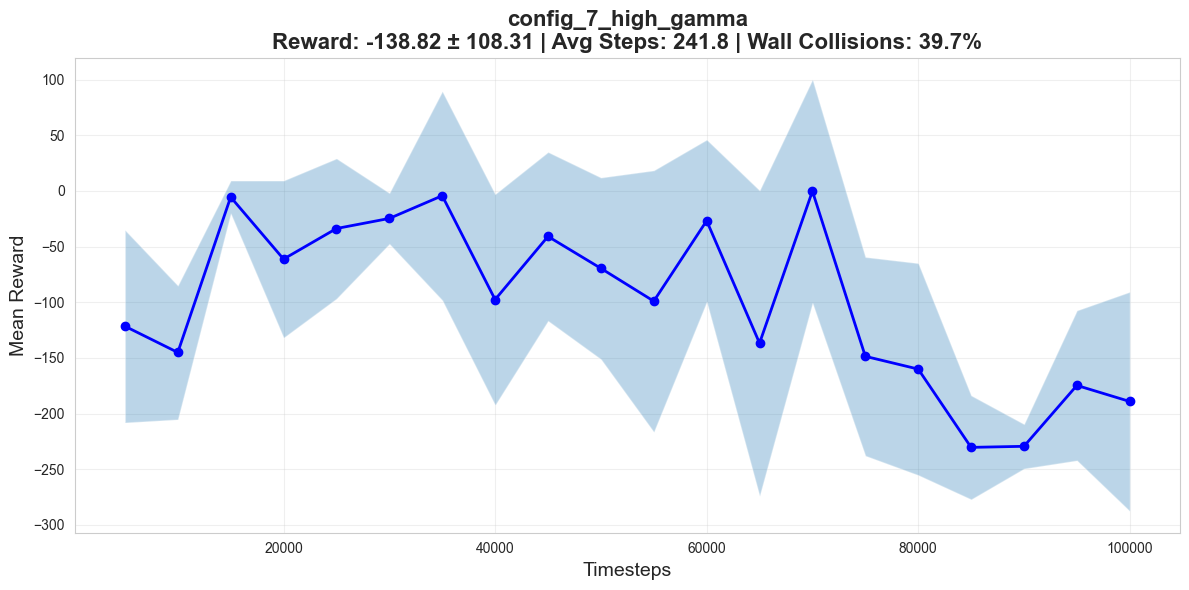


RESULTS for config_7_high_gamma:
   Mean Reward: -138.82 ± 108.31
   Avg Episode Length: 241.8 steps
   Wall Collision Rate: 39.70%
   Scan Efficiency: 7.00%
   Avg Pickup Attempts: 61.11
   Avg Time to Find Survivor: 74.9 steps
   Training Time: 189.6s (3.2 min)
   Saved to: ../models/ppo\config_7_high_gamma


Progress: 8/11 configurations

Training: config_8_high_entropy
📝 High Entropy - More exploration

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =   -3.97 ± 18.55

[Eval] Step  10000: Reward =  -65.04 ± 82.99

[Eval] Step  15000: Reward = -146.64 ± 110.18

[Eval] Step  20000: Reward = -121.19 ± 136.61

[Eval] Step  25000: Reward =  -77.21 ± 125.56

[Eval] Step  30000: Reward = -163.52 ± 100.95

[Eval] Step  35000: Reward = -173.99 ± 113.32

[Eval] Step  40000: Reward = -174.91 ± 74.10

[Eval] Step  45000: Reward = -207.40 ± 76.09

[Eval] Step  50000: Reward = -167.66 ± 99.54

[Eval] Step  55000: Reward = -229.46 ± 11.76

[Eval] Step  60000: Reward = -201.66 ± 100.56

[Eval] Step  65000: Reward = -238.19 ± 14.97

[Eval] Step  70000: Reward = -192.10 ± 104.03

[Eval] Step  75000: Reward = -162.11 ± 95.11

[Eval] Step  80000: Reward = -216.12 ± 33.17

[Eval] Step  85000: Reward = -180.63 ± 80.62

[Eval] Step  90000: Reward = -150.77 ± 102.91

[Eval] Step  95000: Reward = -205.98 ± 57.75

[Eval] Step 100000: Reward = -224.43 ± 45.23


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 46.92% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 93.15% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 46.92% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 93.15% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 92.38% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 93.78% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 92.38% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 93.78% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 238.1 steps
   Wall Collision Rate: 60.59%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 68.04
   Avg Time to Find Survivor: 47.3 steps (55/100 fo

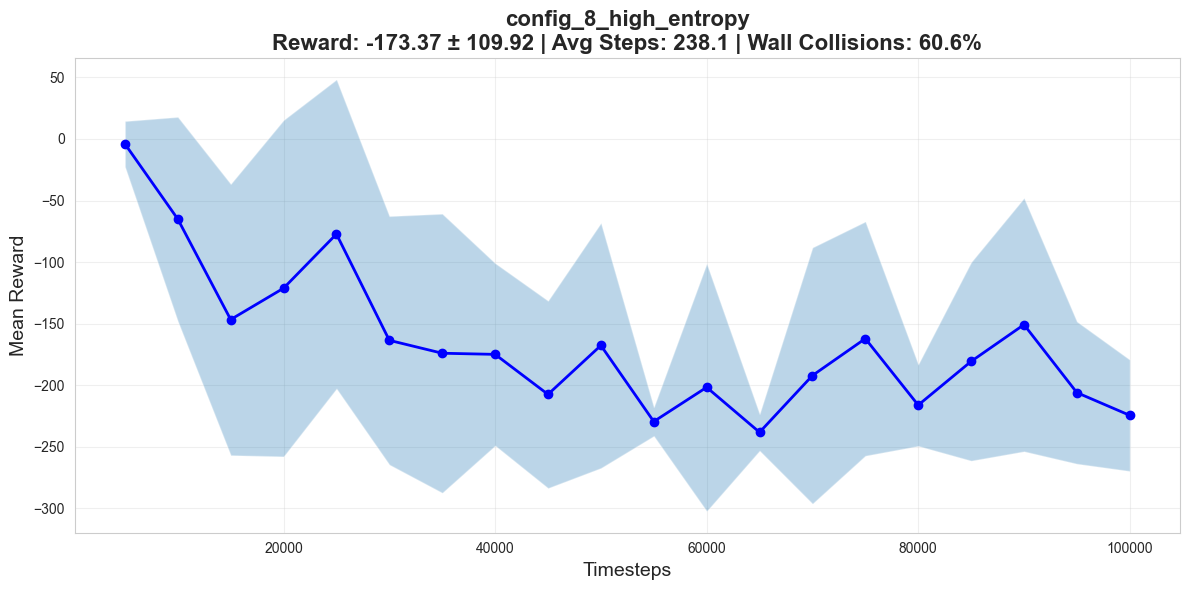


RESULTS for config_8_high_entropy:
   Mean Reward: -173.37 ± 109.92
   Avg Episode Length: 238.1 steps
   Wall Collision Rate: 60.59%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 68.04
   Avg Time to Find Survivor: 47.3 steps
   Training Time: 137.9s (2.3 min)
   Saved to: ../models/ppo\config_8_high_entropy


Progress: 9/11 configurations

Training: config_9_low_entropy
📝 Low Entropy - Pure exploitation

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -43.98 ± 88.17

[Eval] Step  10000: Reward =  -16.09 ± 16.45

[Eval] Step  15000: Reward =  -12.27 ± 26.28

[Eval] Step  20000: Reward =    0.24 ±  0.25

[Eval] Step  25000: Reward =    0.09 ±  0.47

[Eval] Step  30000: Reward =   -0.06 ±  0.43

[Eval] Step  35000: Reward =    0.27 ±  0.42

[Eval] Step  40000: Reward =    0.24 ±  0.53

[Eval] Step  45000: Reward =    0.33 ±  0.52

[Eval] Step  50000: Reward =    0.33 ±  0.43

[Eval] Step  55000: Reward =    0.30 ±  0.33

[Eval] Step  60000: Reward =    0.30 ±  0.45

[Eval] Step  65000: Reward =    0.18 ±  0.37

[Eval] Step  70000: Reward =    0.21 ±  0.40

[Eval] Step  75000: Reward =    0.33 ±  0.41

[Eval] Step  80000: Reward =    0.45 ±  0.35

[Eval] Step  85000: Reward =    0.36 ±  0.39

[Eval] Step  90000: Reward =    0.18 ±  0.49

[Eval] Step  95000: Reward =    0.51 ±  0.30

[Eval] Step 100000: Reward =    0.33 ±  0.45


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 2.3 steps (3/100 found)

📊 Eval

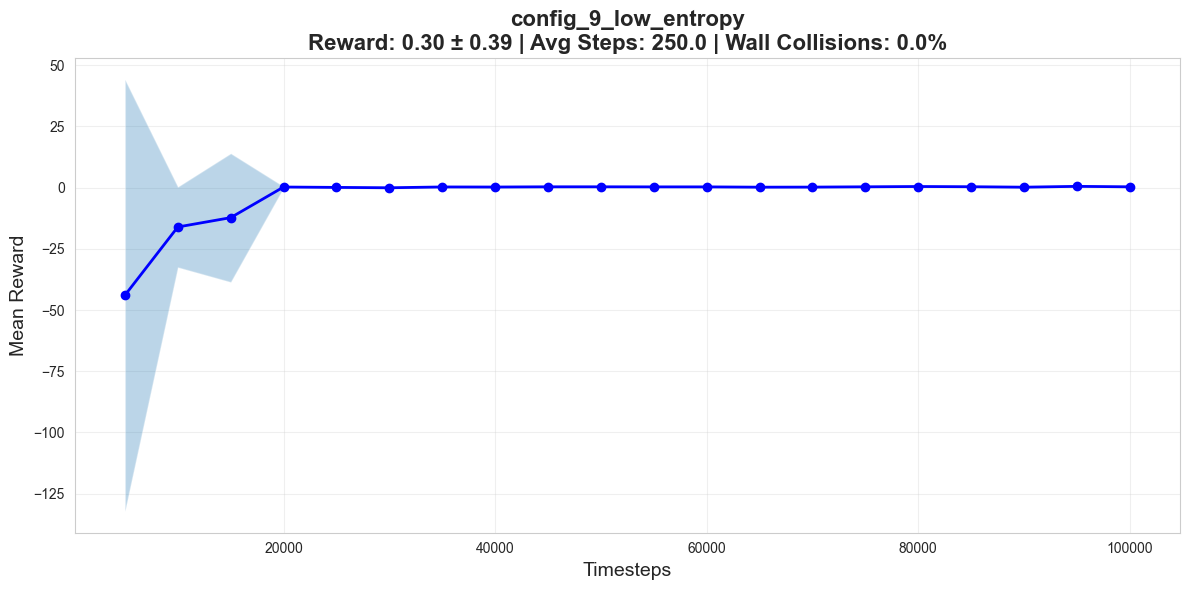


RESULTS for config_9_low_entropy:
   Mean Reward: 0.30 ± 0.39
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 2.3 steps
   Training Time: 149.9s (2.5 min)
   Saved to: ../models/ppo\config_9_low_entropy


Progress: 10/11 configurations

Training: config_10_optimized
📝 Optimized - Best guess for task

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -99.82 ± 50.86

[Eval] Step  10000: Reward =  -91.88 ± 106.72

[Eval] Step  15000: Reward =  -19.94 ± 89.43

[Eval] Step  20000: Reward =  -60.01 ± 79.11

[Eval] Step  25000: Reward =  -78.31 ± 74.78

[Eval] Step  30000: Reward =  -59.76 ± 96.87

[Eval] Step  35000: Reward =  -40.50 ± 75.84

[Eval] Step  40000: Reward =  -80.79 ± 103.07

[Eval] Step  45000: Reward =  -65.67 ± 103.45

[Eval] Step  50000: Reward = -100.86 ± 116.11

[Eval] Step  55000: Reward = -171.20 ± 94.72

[Eval] Step  60000: Reward =  -91.63 ± 104.39

[Eval] Step  65000: Reward = -183.24 ± 94.47

[Eval] Step  70000: Reward = -179.57 ± 80.70

[Eval] Step  75000: Reward = -226.10 ± 43.95

[Eval] Step  80000: Reward = -215.22 ± 75.82

[Eval] Step  85000: Reward = -214.43 ± 73.14

[Eval] Step  90000: Reward = -184.02 ± 77.45

[Eval] Step  95000: Reward = -153.79 ± 94.15

[Eval] Step 100000: Reward = -214.93 ± 53.89


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 95.98% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 93.13% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 95.98% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 93.13% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 31.73% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 31.73% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 233.6 steps
   Wall Collision Rate: 37.27%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 91.90
   Avg Time to Find Survivor: 69.4 steps (21/100 foun

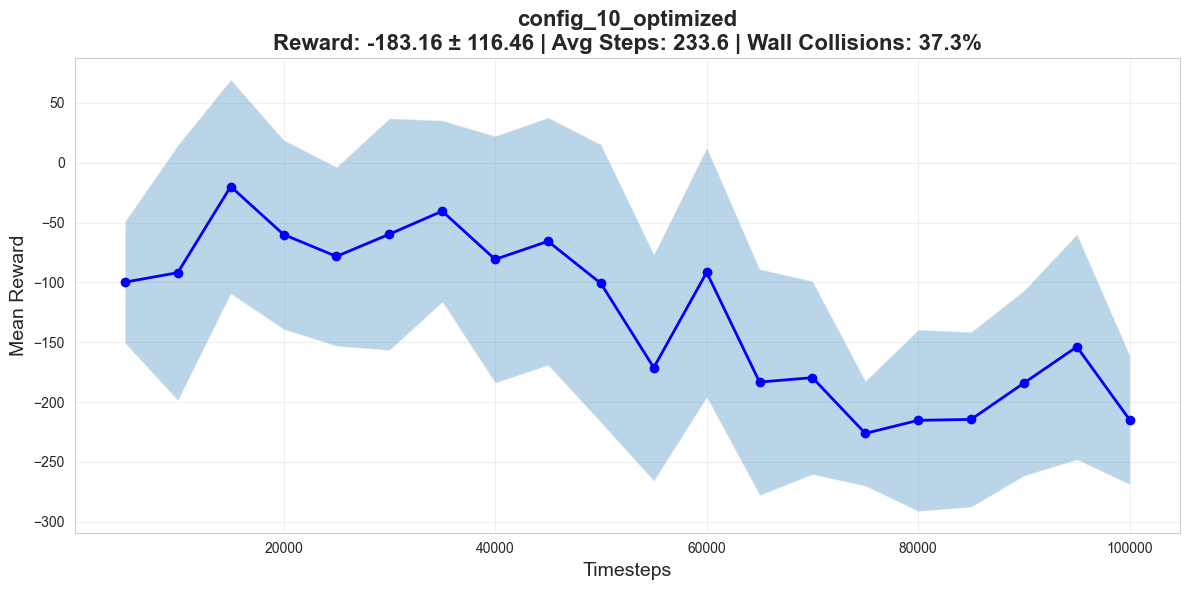


RESULTS for config_10_optimized:
   Mean Reward: -183.16 ± 116.46
   Avg Episode Length: 233.6 steps
   Wall Collision Rate: 37.27%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 91.90
   Avg Time to Find Survivor: 69.4 steps
   Training Time: 263.7s (4.4 min)
   Saved to: ../models/ppo\config_10_optimized


Progress: 11/11 configurations

Training: config_11_many_epochs
📝 Many Epochs - Sample efficient

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -96.50 ± 101.72

[Eval] Step  10000: Reward =  -63.48 ± 81.40

[Eval] Step  15000: Reward =  -45.31 ± 92.07

[Eval] Step  20000: Reward =  -50.51 ± 81.89

[Eval] Step  25000: Reward =  -29.08 ± 126.51

[Eval] Step  30000: Reward =  -60.68 ± 118.89

[Eval] Step  35000: Reward = -123.49 ± 145.67

[Eval] Step  40000: Reward = -233.87 ± 15.41

[Eval] Step  45000: Reward = -231.89 ± 14.89

[Eval] Step  50000: Reward = -230.81 ± 13.03

[Eval] Step  55000: Reward = -225.81 ± 12.14

[Eval] Step  60000: Reward = -232.33 ± 11.23

[Eval] Step  65000: Reward = -230.75 ± 14.60

[Eval] Step  70000: Reward =  -50.83 ± 151.81

[Eval] Step  75000: Reward = -241.05 ± 15.21

[Eval] Step  80000: Reward =  -69.44 ± 167.10

[Eval] Step  85000: Reward = -164.85 ± 117.86

[Eval] Step  90000: Reward =  -69.13 ± 162.74

[Eval] Step  95000: Reward =   90.30 ± 25.09

[Eval] Step 100000: Reward =   45.44 ± 107.45


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 4 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 96.39% | Scan Eff: 0.00%
  Episode 3: Steps: 8 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 5: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 4 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 96.39% | Scan Eff: 0.00%
  Episode 3: Steps: 8 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 5: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 73.7 steps
   Wall Collision Rate: 20.41%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 1.72
   Avg Time to Find Survivor: 26.4 steps (89/100 found)

📊 Evaluati

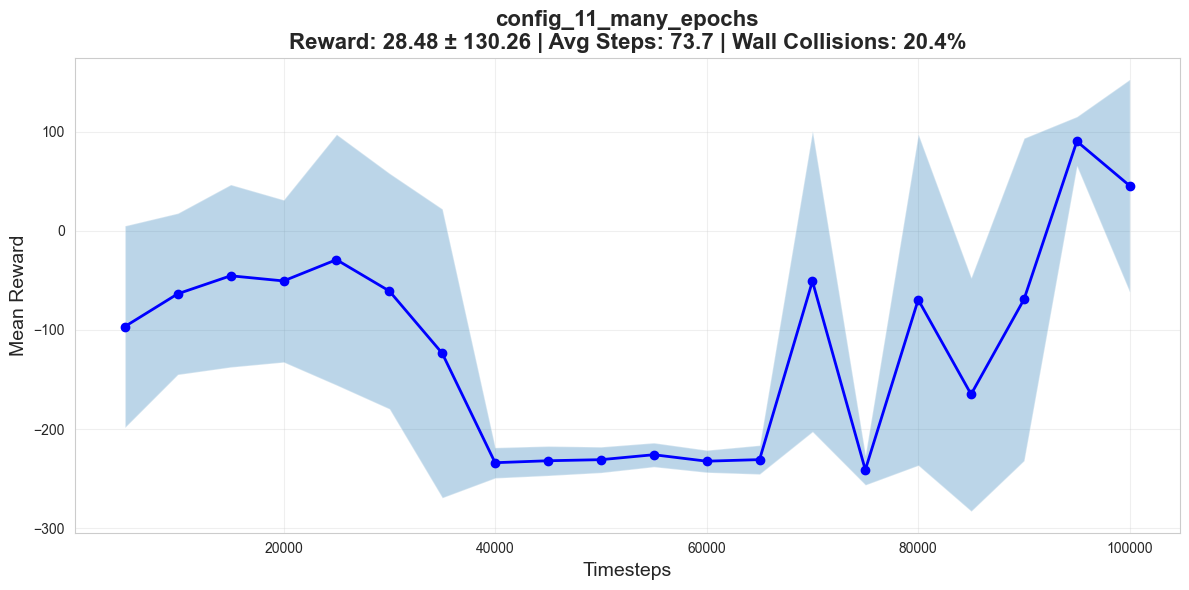


RESULTS for config_11_many_epochs:
   Mean Reward: 28.48 ± 130.26
   Avg Episode Length: 73.7 steps
   Wall Collision Rate: 20.41%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 1.72
   Avg Time to Find Survivor: 26.4 steps
   Training Time: 297.3s (5.0 min)
   Saved to: ../models/ppo\config_11_many_epochs


ALL TRAINING COMPLETE!
   Trained 11/11 configurations successfully


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: TRAIN ALL CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
MAIN TRAINING CELL - This will take a while!

Adjust total_timesteps based on your time:
- 50k = ~30-60 min total (quick test)
- 100k = ~1-2 hours total (recommended)
- 200k = ~2-4 hours total (better results)

You can also train individual configs by commenting out others
"""

# CONFIGURATION
TOTAL_TIMESTEPS = 100000  # Adjust this based on your compute time

print("\n" + "="*80)
print("PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT")
print("="*80)
print(f"\nTotal Configs: {len(PPO_CONFIGS)}")
print(f"Timesteps per config: {TOTAL_TIMESTEPS:,}")
print(f"Total training timesteps: {TOTAL_TIMESTEPS * len(PPO_CONFIGS):,}")
print(f"\nThis will take approximately {(TOTAL_TIMESTEPS * len(PPO_CONFIGS)) / 50000:.1f} hours")
print(f"    (Estimate: ~{TOTAL_TIMESTEPS / 50000 * 5:.0f} min per config)")
print("\n" + "="*80 + "\n")

# Train all configurations
all_results = []

for i, (config_name, config) in enumerate(PPO_CONFIGS.items(), 1):
    print(f"\nProgress: {i}/{len(PPO_CONFIGS)} configurations")
    
    try:
        results = train_ppo_config(config_name, config, TOTAL_TIMESTEPS)
        all_results.append(results)
    except Exception as e:
        print(f"ERROR training {config_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("ALL TRAINING COMPLETE!")
print(f"   Trained {len(all_results)}/{len(PPO_CONFIGS)} configurations successfully")
print("="*80)

In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: GENERATE COMPARISON REPORT
# ═══════════════════════════════════════════════════════════════════════
"""
Generate comprehensive analysis and performance summary
"""

if len(all_results) == 0:
    print("No results to compare!")
else:
    # Create comparison directory
    comp_dir = "../models/ppo/comparison"
    os.makedirs(comp_dir, exist_ok=True)
    
    # Sort by mean reward for analysis
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    
    print("\n" + "="*80)
    print("📊 PPO HYPERPARAMETER TUNING - SUMMARY EVALUATION")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────────────
    # KEY OBSERVATIONS
    # ─────────────────────────────────────────────────────────────────────
    
    print("\n🔍 KEY OBSERVATIONS:\n")
    
    # 1. Learning Rate Analysis
    high_lr = next((r for r in all_results if r['config_name'] == 'config_2_high_lr'), None)
    low_lr = next((r for r in all_results if r['config_name'] == 'config_3_low_lr'), None)
    baseline = next((r for r in all_results if r['config_name'] == 'config_1_baseline'), None)
    
    if high_lr and low_lr and baseline:
        lr_values = [
            (high_lr['config']['learning_rate'], high_lr['mean_reward'], 'High LR'),
            (baseline['config']['learning_rate'], baseline['mean_reward'], 'Baseline'),
            (low_lr['config']['learning_rate'], low_lr['mean_reward'], 'Low LR')
        ]
        best_lr = max(lr_values, key=lambda x: x[1])
        print(f"1. LEARNING RATE: {best_lr[2]} ({best_lr[0]:.0e}) performed best ({best_lr[1]:.2f} reward)")
        if best_lr[2] == 'Baseline':
            print("   → Standard learning rate (3e-4) is well-suited for this task")
        elif best_lr[2] == 'High LR':
            print("   → Aggressive learning beneficial; PPO's clipping prevents instability")
        else:
            print("   → Conservative learning works best; task needs careful policy updates")
    
    # 2. Gamma Analysis
    low_gamma = next((r for r in all_results if r['config_name'] == 'config_6_low_gamma'), None)
    high_gamma = next((r for r in all_results if r['config_name'] == 'config_7_high_gamma'), None)
    
    if low_gamma and high_gamma and baseline:
        gamma_values = [
            (low_gamma['config']['gamma'], low_gamma['mean_reward'], 'Low γ (0.95)'),
            (baseline['config']['gamma'], baseline['mean_reward'], 'Baseline γ (0.99)'),
            (high_gamma['config']['gamma'], high_gamma['mean_reward'], 'High γ (0.995)')
        ]
        best_gamma = max(gamma_values, key=lambda x: x[1])
        print(f"\n2. DISCOUNT FACTOR (γ): {best_gamma[2]} achieved best performance ({best_gamma[1]:.2f} reward)")
        if best_gamma[0] >= 0.99:
            print("   → Long-term planning crucial; agent values future rewards highly")
        else:
            print("   → Short-term rewards sufficient; immediate actions more important")
    
    # 3. Batch Size Analysis
    large_batch = next((r for r in all_results if r['config_name'] == 'config_4_large_batch'), None)
    small_batch = next((r for r in all_results if r['config_name'] == 'config_5_small_batch'), None)
    
    if large_batch and small_batch and baseline:
        batch_values = [
            (small_batch['config']['batch_size'], small_batch['mean_reward'], 'Small (32)'),
            (baseline['config']['batch_size'], baseline['mean_reward'], 'Baseline (64)'),
            (large_batch['config']['batch_size'], large_batch['mean_reward'], 'Large (256)')
        ]
        best_batch = max(batch_values, key=lambda x: x[1])
        print(f"\n3. BATCH SIZE: {best_batch[2]} showed best results ({best_batch[1]:.2f} reward)")
        if best_batch[0] >= 128:
            print("   → Larger batches provide stable gradients and smooth learning")
        else:
            print("   → Smaller batches enable faster adaptation to environment dynamics")
    
    # 4. Entropy Coefficient (PPO-specific)
    high_ent = next((r for r in all_results if r['config_name'] == 'config_8_high_entropy'), None)
    low_ent = next((r for r in all_results if r['config_name'] == 'config_9_low_entropy'), None)
    
    if high_ent and low_ent and baseline:
        ent_values = [
            (low_ent['config']['ent_coef'], low_ent['mean_reward'], 'No exploration (0.0)'),
            (baseline['config']['ent_coef'], baseline['mean_reward'], 'Baseline (0.01)'),
            (high_ent['config']['ent_coef'], high_ent['mean_reward'], 'High exploration (0.1)')
        ]
        best_ent = max(ent_values, key=lambda x: x[1])
        print(f"\n4. EXPLORATION (Entropy): {best_ent[2]} was most effective ({best_ent[1]:.2f} reward)")
        if best_ent[0] >= 0.05:
            print("   → Strong exploration bonus helps discover diverse strategies")
        elif best_ent[0] == 0.0:
            print("   → Pure exploitation sufficient; optimal policy is straightforward")
        else:
            print("   → Moderate exploration balances discovery and exploitation")
    
    # 5. Overall Best Configuration
    best_overall = results_sorted[0]
    print(f"\n5. BEST OVERALL: {best_overall['config_name']}")
    print(f"   • Mean Reward: {best_overall['mean_reward']:.2f} ± {best_overall['std_reward']:.2f}")
    print(f"   • Avg Episode Length: {best_overall['avg_episode_length']:.1f} steps")
    print(f"   • Scan Efficiency: {best_overall['scan_efficiency']:.2%}")
    print(f"   • Avg Pickup Attempts: {best_overall['avg_pickup_attempts']:.2f}")
    print(f"   • Key Settings: LR={best_overall['config']['learning_rate']:.0e}, "
          f"γ={best_overall['config']['gamma']}, "
          f"Batch={best_overall['config']['batch_size']}, "
          f"Entropy={best_overall['config']['ent_coef']}")
    
    # ─────────────────────────────────────────────────────────────────────
    # PERFORMANCE TABLE (In training order)
    # ─────────────────────────────────────────────────────────────────────
    
    print("\n" + "="*80)
    print("📋 CONFIGURATION PERFORMANCE TABLE")
    print("="*80)
    print("\n| Config | Mean Reward | Scan Eff | Pickup Attempts | Episode Length |")
    print("|--------|-------------|----------|-----------------|----------------|")
    
    # Display in original training order
    for result in all_results:
        config_display = result['config_name'].replace('config_', '').replace('_', ' ').title()
        print(f"| {config_display:<30} | "
              f"{result['mean_reward']:>7.2f} ± {result['std_reward']:>4.2f} | "
              f"{result['scan_efficiency']:>7.1%} | "
              f"{result['avg_pickup_attempts']:>15.2f} | "
              f"{result['avg_episode_length']:>14.1f} |")
    
    print("\n" + "="*80)
    
    # Save detailed results
    with open(os.path.join(comp_dir, "all_results.json"), 'w') as f:
        json.dump(all_results, f, indent=4)
    
    # Save CSV
    import csv
    csv_path = os.path.join(comp_dir, "results_summary.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Config', 'Mean Reward', 'Std Reward', 'Scan Efficiency', 'Pickup Attempts', 'Episode Length', 'Total Timesteps'])
        for result in all_results:
            writer.writerow([
                result['config_name'],
                f"{result['mean_reward']:.2f}",
                f"{result['std_reward']:.2f}",
                f"{result['scan_efficiency']:.3f}",
                f"{result['avg_pickup_attempts']:.2f}",
                f"{result['avg_episode_length']:.1f}",
                result['total_timesteps']
            ])
    
    print(f"\n💾 Results saved to:")
    print(f"   • JSON: {comp_dir}/all_results.json")
    print(f"   • CSV: {csv_path}")
    print("\n" + "="*80)



📊 PPO HYPERPARAMETER TUNING - SUMMARY EVALUATION

🔍 KEY OBSERVATIONS:

1. LEARNING RATE: High LR (5e-03) performed best (-55.52 reward)
   → Aggressive learning beneficial; PPO's clipping prevents instability

2. DISCOUNT FACTOR (γ): Low γ (0.95) achieved best performance (-92.25 reward)
   → Short-term rewards sufficient; immediate actions more important

3. BATCH SIZE: Small (32) showed best results (-53.04 reward)
   → Smaller batches enable faster adaptation to environment dynamics

4. EXPLORATION (Entropy): No exploration (0.0) was most effective (0.30 reward)
   → Pure exploitation sufficient; optimal policy is straightforward

5. BEST OVERALL: config_11_many_epochs
   • Mean Reward: 28.48 ± 130.26
   • Avg Episode Length: 73.7 steps
   • Scan Efficiency: 0.00%
   • Avg Pickup Attempts: 1.72
   • Key Settings: LR=3e-04, γ=0.99, Batch=64, Entropy=0.05

📋 CONFIGURATION PERFORMANCE TABLE

| Config | Mean Reward | Scan Eff | Pickup Attempts | Episode Length |
|--------|-------------

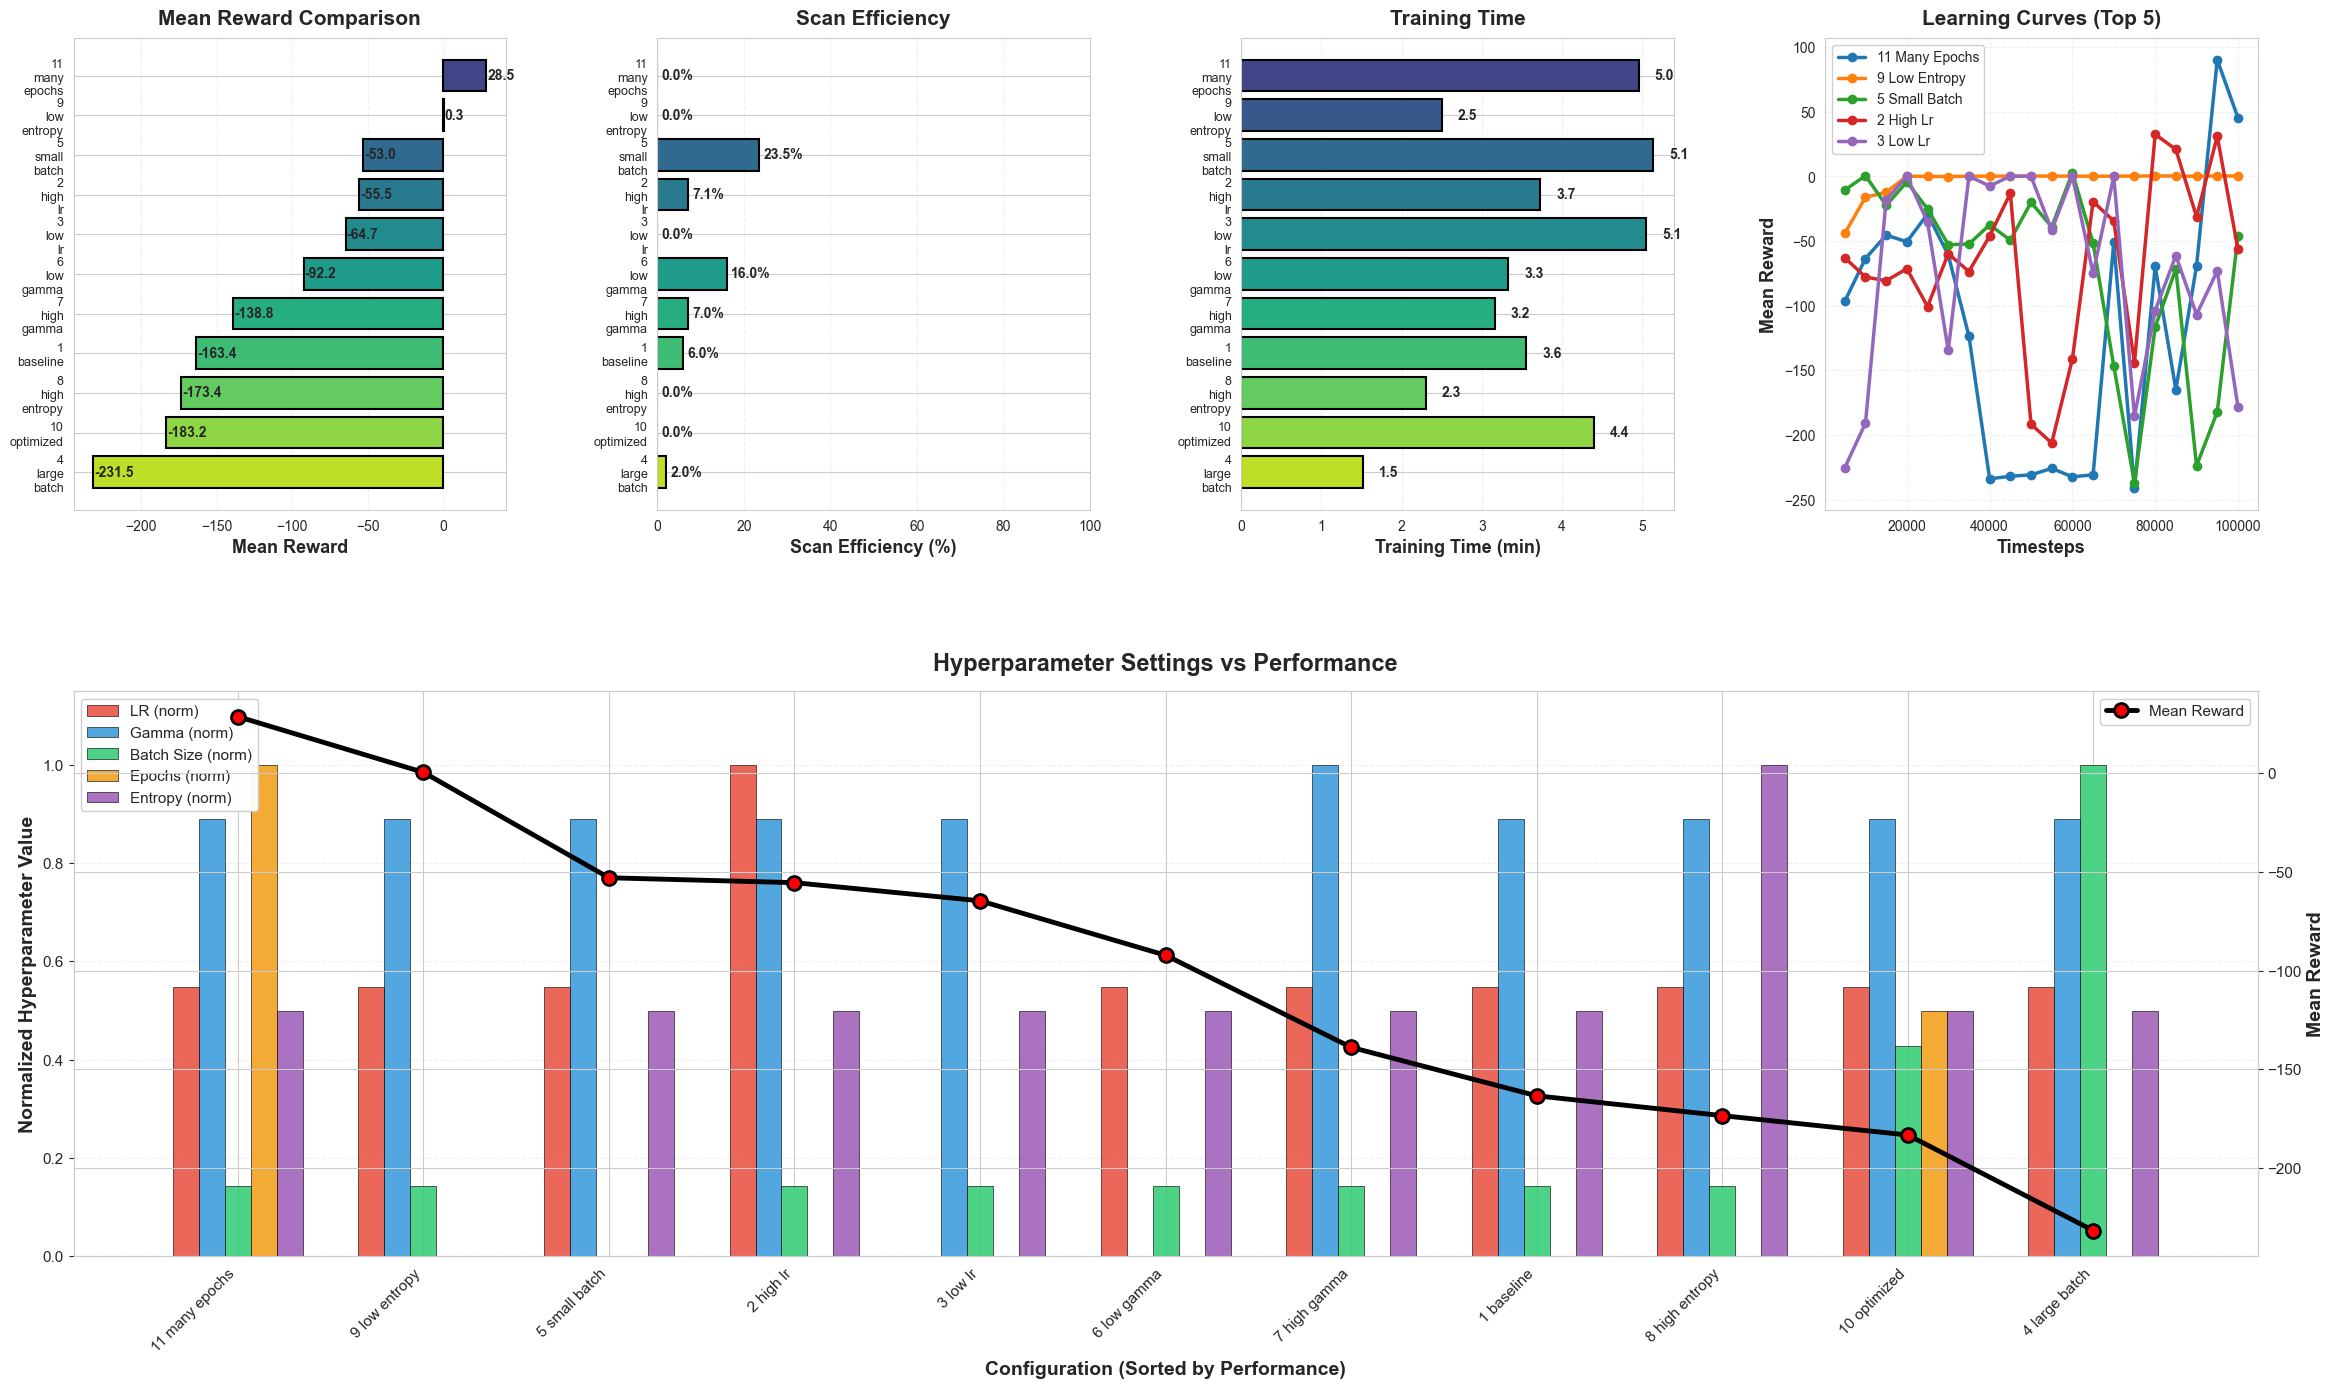


✅ Comprehensive analysis plot saved to: ../models/ppo/comparison/ppo_comprehensive_analysis.png


In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: COMPREHENSIVE VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════
"""
Create all comparison visualizations in one comprehensive figure
"""

if len(all_results) > 0:
    # Create large figure with 2 rows: 4 plots top, 1 large plot bottom
    fig = plt.figure(figsize=(24, 14))
    gs = fig.add_gridspec(2, 4, height_ratios=[1, 1.2], hspace=0.35, wspace=0.35,
                          left=0.06, right=0.97, top=0.95, bottom=0.08)
    
    # Prepare data
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    configs = [r['config_name'].replace('config_', '').replace('_', '\n') 
               for r in results_sorted]
    rewards = [r['mean_reward'] for r in results_sorted]
    scan_efficiencies = [r['scan_efficiency'] * 100 for r in results_sorted]  # Convert to percentage
    pickup_attempts = [r['avg_pickup_attempts'] for r in results_sorted]
    times = [r['training_time'] / 60 for r in results_sorted]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(configs)))
    
    # ─────────────────────────────────────────────────────────────────────
    # TOP ROW: 4 comparison plots
    # ─────────────────────────────────────────────────────────────────────
    
    # Plot 1: Mean Rewards
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.barh(configs, rewards, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Mean Reward', fontsize=13, fontweight='bold')
    ax1.set_title('Mean Reward Comparison', fontsize=15, fontweight='bold', pad=10)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='y', labelsize=9)
    ax1.tick_params(axis='x', labelsize=10)
    for bar, val in zip(bars1, rewards):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    ax1.invert_yaxis()  # Best on top
    
    # Plot 2: Scan Efficiency
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.barh(configs, scan_efficiencies, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Scan Efficiency (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Scan Efficiency', fontsize=15, fontweight='bold', pad=10)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='y', labelsize=9)
    ax2.tick_params(axis='x', labelsize=10)
    ax2.set_xlim(0, 100)
    for bar, val in zip(bars2, scan_efficiencies):
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=10, fontweight='bold')
    ax2.invert_yaxis()  # Best on top
    
    # Plot 3: Training Time
    ax3 = fig.add_subplot(gs[0, 2])
    bars3 = ax3.barh(configs, times, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Training Time (min)', fontsize=13, fontweight='bold')
    ax3.set_title('Training Time', fontsize=15, fontweight='bold', pad=10)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.tick_params(axis='y', labelsize=9)
    ax3.tick_params(axis='x', labelsize=10)
    for bar, val in zip(bars3, times):
        ax3.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    ax3.invert_yaxis()  # Best on top
    
    # Plot 4: Learning Curves (Top 5)
    ax4 = fig.add_subplot(gs[0, 3])
    for i, result in enumerate(results_sorted[:5]):
        if 'eval_timesteps' in result and len(result['eval_timesteps']) > 0:
            label = result['config_name'].replace('config_', '').replace('_', ' ').title()
            ax4.plot(result['eval_timesteps'], result['eval_rewards'], 
                    label=label, linewidth=2.5, marker='o', markersize=6)
    ax4.set_xlabel('Timesteps', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Reward', fontsize=13, fontweight='bold')
    ax4.set_title('Learning Curves (Top 5)', fontsize=15, fontweight='bold', pad=10)
    ax4.legend(loc='best', fontsize=10, framealpha=0.95)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.tick_params(axis='both', labelsize=10)
    
    # ─────────────────────────────────────────────────────────────────────
    # BOTTOM ROW: Hyperparameter correlation analysis (spans full width)
    # ─────────────────────────────────────────────────────────────────────
    
    ax5 = fig.add_subplot(gs[1, :])
    
    # Extract hyperparameters and performance
    lrs = [r['config']['learning_rate'] for r in results_sorted]
    gammas = [r['config']['gamma'] for r in results_sorted]
    batches = [r['config']['batch_size'] for r in results_sorted]
    n_steps = [r['config']['n_steps'] for r in results_sorted]
    n_epochs = [r['config']['n_epochs'] for r in results_sorted]
    ent_coefs = [r['config']['ent_coef'] for r in results_sorted]
    rewards_sorted = [r['mean_reward'] for r in results_sorted]
    
    # Create positions for grouped bars
    x = np.arange(len(results_sorted))
    width = 0.14
    
    # Normalize values to 0-1 for comparison
    norm_lrs = [(np.log10(lr) - np.log10(min(lrs))) / (np.log10(max(lrs)) - np.log10(min(lrs))) if max(lrs) != min(lrs) else 0.5 for lr in lrs]
    norm_gammas = [(g - min(gammas)) / (max(gammas) - min(gammas)) if max(gammas) != min(gammas) else 0.5 for g in gammas]
    norm_batches = [(b - min(batches)) / (max(batches) - min(batches)) if max(batches) != min(batches) else 0.5 for b in batches]
    norm_epochs = [(e - min(n_epochs)) / (max(n_epochs) - min(n_epochs)) if max(n_epochs) != min(n_epochs) else 0.5 for e in n_epochs]
    norm_ent = [(e - min(ent_coefs)) / (max(ent_coefs) - min(ent_coefs)) if max(ent_coefs) != min(ent_coefs) else 0.5 for e in ent_coefs]
    
    # Plot grouped bars
    ax5.bar(x - 2*width, norm_lrs, width, label='LR (norm)', alpha=0.85, color='#e74c3c', edgecolor='black', linewidth=0.5)
    ax5.bar(x - width, norm_gammas, width, label='Gamma (norm)', alpha=0.85, color='#3498db', edgecolor='black', linewidth=0.5)
    ax5.bar(x, norm_batches, width, label='Batch Size (norm)', alpha=0.85, color='#2ecc71', edgecolor='black', linewidth=0.5)
    ax5.bar(x + width, norm_epochs, width, label='Epochs (norm)', alpha=0.85, color='#f39c12', edgecolor='black', linewidth=0.5)
    ax5.bar(x + 2*width, norm_ent, width, label='Entropy (norm)', alpha=0.85, color='#9b59b6', edgecolor='black', linewidth=0.5)
    
    # Overlay performance as line
    ax5_twin = ax5.twinx()
    ax5_twin.plot(x, rewards_sorted, 'ko-', linewidth=3.5, markersize=10, 
                  label='Mean Reward', markerfacecolor='red', markeredgewidth=2, markeredgecolor='black')
    ax5_twin.set_ylabel('Mean Reward', fontsize=14, fontweight='bold')
    ax5_twin.tick_params(axis='y', labelsize=11)
    
    # Formatting
    ax5.set_xlabel('Configuration (Sorted by Performance)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Normalized Hyperparameter Value', fontsize=14, fontweight='bold')
    ax5.set_title('Hyperparameter Settings vs Performance', fontsize=17, fontweight='bold', pad=15)
    ax5.set_xticks(x)
    ax5.set_xticklabels([c.replace('\n', ' ') for c in configs], rotation=45, ha='right', fontsize=10)
    ax5.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax5_twin.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    ax5.set_ylim(0, 1.15)
    ax5.tick_params(axis='both', labelsize=11)
    
    plt.savefig('../models/ppo/comparison/ppo_comprehensive_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Comprehensive analysis plot saved to: ../models/ppo/comparison/ppo_comprehensive_analysis.png")


BEST PERFORMING CONFIGURATION

Config: config_11_many_epochs
Description: Many Epochs - Sample efficient

PERFORMANCE METRICS:
   Mean Reward: 28.48 ± 130.26
   Avg Episode Length: 73.7 steps
   Wall Collision Rate: 20.41%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 1.72
   Avg Time to Find Survivor: 26.4 steps
   Training Time: 5.0 minutes

HYPERPARAMETERS:
   • Learning Rate: 3e-04
   • Gamma: 0.99
   • Batch Size: 64
   • N Steps: 2048
   • N Epochs: 20
   • Clip Range: 0.2
   • GAE Lambda: 0.95
   • Entropy Coef: 0.05
   • Network: [64, 64]

Model saved at:
   ../models/ppo/config_11_many_epochs/final_model.zip

Use this model for your video demonstration!

Use this model for your video demonstration!


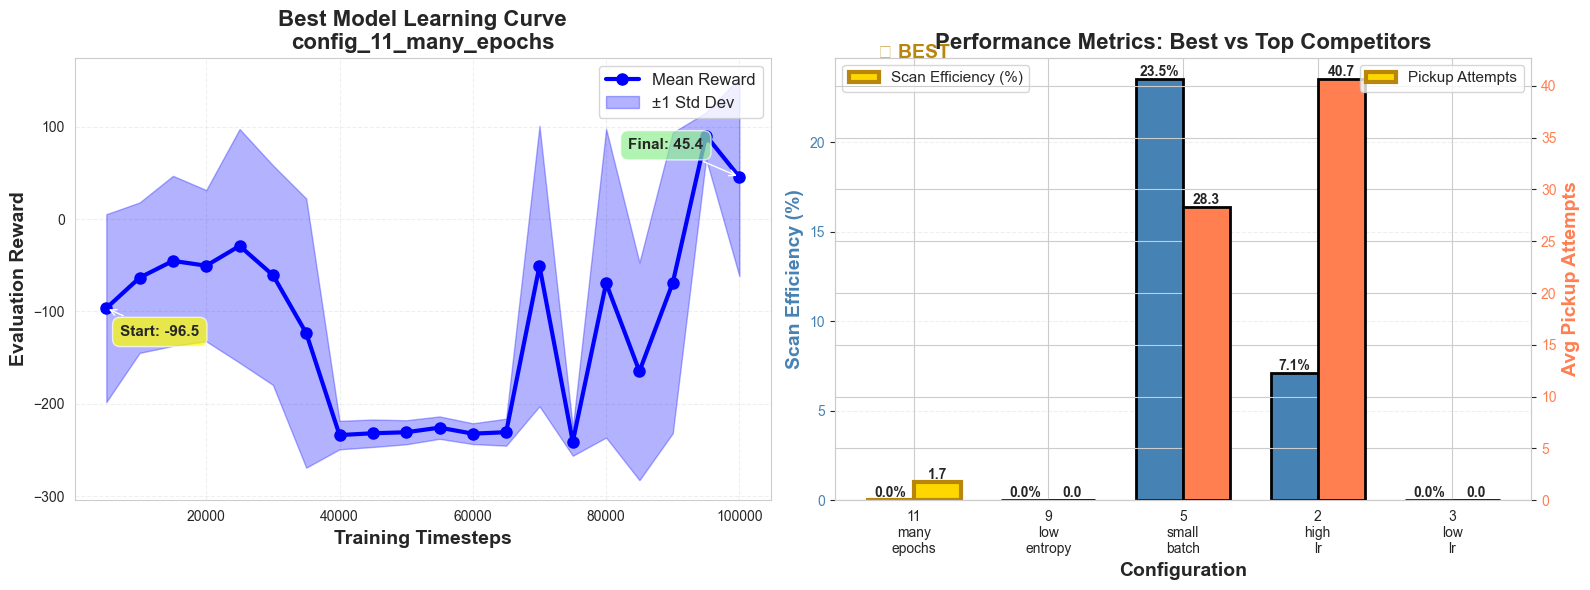


Best model plots saved to: ../models/ppo/config_11_many_epochs/best_model_analysis.png


In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: BEST MODEL SUMMARY WITH VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed summary of best model with dedicated visualizations
"""

if len(all_results) > 0:
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    best = results_sorted[0]
    
    print("\n" + "="*80)
    print("BEST PERFORMING CONFIGURATION")
    print("="*80)
    print(f"\nConfig: {best['config_name']}")
    print(f"Description: {best['config']['description']}")
    print(f"\nPERFORMANCE METRICS:")
    print(f"   Mean Reward: {best['mean_reward']:.2f} ± {best['std_reward']:.2f}")
    print(f"   Avg Episode Length: {best['avg_episode_length']:.1f} steps")
    print(f"   Wall Collision Rate: {best['wall_collision_rate']:.2%}")
    print(f"   Scan Efficiency: {best['scan_efficiency']:.2%}")
    print(f"   Avg Pickup Attempts: {best['avg_pickup_attempts']:.2f}")
    if best['avg_time_to_find_survivor'] is not None:
        print(f"   Avg Time to Find Survivor: {best['avg_time_to_find_survivor']:.1f} steps")
    print(f"   Training Time: {best['training_time']/60:.1f} minutes")
    
    print(f"\nHYPERPARAMETERS:")
    print(f"   • Learning Rate: {best['config']['learning_rate']:.0e}")
    print(f"   • Gamma: {best['config']['gamma']}")
    print(f"   • Batch Size: {best['config']['batch_size']}")
    print(f"   • N Steps: {best['config']['n_steps']}")
    print(f"   • N Epochs: {best['config']['n_epochs']}")
    print(f"   • Clip Range: {best['config']['clip_range']}")
    print(f"   • GAE Lambda: {best['config']['gae_lambda']}")
    print(f"   • Entropy Coef: {best['config']['ent_coef']}")
    print(f"   • Network: {best['config']['policy_kwargs']['net_arch']}")
    
    print(f"\nModel saved at:")
    print(f"   ../models/ppo/{best['config_name']}/final_model.zip")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────────────
    # Create dedicated plots for best model
    # ─────────────────────────────────────────────────────────────────────
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Learning Curve with Confidence Interval
    ax1 = axes[0]
    if 'eval_timesteps' in best and len(best['eval_timesteps']) > 0:
        timesteps = best['eval_timesteps']
        rewards = best['eval_rewards']
        stds = best['eval_stds']
        
        ax1.plot(timesteps, rewards, 'b-', linewidth=3, marker='o', markersize=8, 
                label='Mean Reward')
        ax1.fill_between(timesteps, 
                        np.array(rewards) - np.array(stds),
                        np.array(rewards) + np.array(stds),
                        alpha=0.3, color='blue', label='±1 Std Dev')
        
        ax1.set_xlabel('Training Timesteps', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Evaluation Reward', fontsize=14, fontweight='bold')
        ax1.set_title(f'Best Model Learning Curve\n{best["config_name"]}', 
                     fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12, loc='best')
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Add annotations for first and last points
        ax1.annotate(f'Start: {rewards[0]:.1f}', 
                    xy=(timesteps[0], rewards[0]),
                    xytext=(10, -20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        ax1.annotate(f'Final: {rewards[-1]:.1f}', 
                    xy=(timesteps[-1], rewards[-1]),
                    xytext=(-80, 20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Plot 2: Performance Metrics Comparison (Best vs Others)
    ax2 = axes[1]
    
    # Top 5 configs for comparison
    top5 = results_sorted[:5]
    config_names = [r['config_name'].replace('config_', '').replace('_', '\n') for r in top5]
    scan_effs = [r['scan_efficiency'] * 100 for r in top5]  # Convert to percentage
    pickup_atts = [r['avg_pickup_attempts'] for r in top5]
    mean_rewards = [r['mean_reward'] for r in top5]  # For annotation positioning
    
    x = np.arange(len(config_names))
    width = 0.35
    
    # Create bars
    bars1 = ax2.bar(x - width/2, scan_effs, width, label='Scan Efficiency (%)', 
                    color='steelblue', edgecolor='black', linewidth=2)
    
    # Create twin axis for pickup attempts
    ax2_twin = ax2.twinx()
    bars2 = ax2_twin.bar(x + width/2, pickup_atts, width, label='Pickup Attempts', 
                        color='coral', edgecolor='black', linewidth=2)
    
    # Highlight best model
    bars1[0].set_color('gold')
    bars1[0].set_edgecolor('darkgoldenrod')
    bars1[0].set_linewidth(3)
    bars2[0].set_color('gold')
    bars2[0].set_edgecolor('darkgoldenrod')
    bars2[0].set_linewidth(3)
    
    # Add value labels
    for bar, val in zip(bars1, scan_effs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    for bar, val in zip(bars2, pickup_atts):
        height = bar.get_height()
        ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Formatting
    ax2.set_xlabel('Configuration', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Scan Efficiency (%)', fontsize=14, fontweight='bold', color='steelblue')
    ax2_twin.set_ylabel('Avg Pickup Attempts', fontsize=14, fontweight='bold', color='coral')
    ax2.set_title('Performance Metrics: Best vs Top Competitors', fontsize=16, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(config_names, fontsize=10)
    ax2.legend(loc='upper left', fontsize=11)
    ax2_twin.legend(loc='upper right', fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='y', labelcolor='steelblue')
    ax2_twin.tick_params(axis='y', labelcolor='coral')
    
    # Add crown emoji annotation for best model
    ax2.text(0, max(scan_effs) * 1.05, '👑 BEST', ha='center', fontsize=14, 
            fontweight='bold', color='darkgoldenrod')
    
    plt.tight_layout()
    
    plt.savefig(f'../models/ppo/{best["config_name"]}/best_model_analysis.png', dpi=200, bbox_inches='tight')
    print(f"\nUse this model for your video demonstration!")
    
    plt.show()
    print(f"\nBest model plots saved to: ../models/ppo/{best['config_name']}/best_model_analysis.png")


In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: LOAD AND TEST BEST MODEL
# ═══════════════════════════════════════════════════════════════════════
"""
Load the best model and run a test episode
This shows you how to use the trained model with detailed performance metrics
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("TESTING BEST MODEL")
    print("="*80)
    
    # Load best model
    best_config = results_sorted[0]['config_name']
    model_path = f"../models/ppo/{best_config}/final_model"
    
    print(f"\nLoading model from: {model_path}")
    best_model = PPO.load(model_path)
    
    # Create test environment
    test_env = FireRescueEnv()
    
    print(f"Running 5 test episodes...\n")
    
    for episode in range(5):
        obs, _ = test_env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action, _ = best_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        
        # Extract performance metrics from info
        wall_collision_rate = info.get('wall_collision_rate', 0) * 100
        scan_efficiency = info.get('scan_efficiency', 0) * 100
        time_to_find = info.get('time_to_find_survivor', None)
        pickup_attempts = info.get('pickup_attempts', 0)
        
        # Display episode metrics
        print(f"   Episode {episode+1}:")
        print(f"      Steps: {steps}")
        print(f"      Reward: {total_reward:>7.2f}")
        print(f"      Wall Collision Rate: {wall_collision_rate:>5.1f}%")
        print(f"      Scan Efficiency: {scan_efficiency:>5.1f}%")
        if time_to_find is not None:
            print(f"      Time to Find Survivor: {time_to_find} steps")
            # Calculate time to drop off (total steps - time to find)
            time_to_dropoff = steps - time_to_find
            print(f"      Time to Drop Off: {time_to_dropoff} steps")
        else:
            print(f"      Time to Find Survivor: Not found")
        print()
    
    test_env.close()
    print("=" * 80)



TESTING BEST MODEL

Loading model from: ../models/ppo/config_11_many_epochs/final_model
Running 5 test episodes...

   Episode 1:
      Steps: 143
      Reward:  -12.43
      Wall Collision Rate:  83.0%
      Scan Efficiency:   0.0%
      Time to Find Survivor: 12 steps
      Time to Drop Off: 131 steps

   Episode 2:
      Steps: 10
      Reward:   97.90
      Wall Collision Rate:   0.0%
      Scan Efficiency:   0.0%
      Time to Find Survivor: 4 steps
      Time to Drop Off: 6 steps

   Episode 3:
      Steps: 143
      Reward:  -12.43
      Wall Collision Rate:  83.0%
      Scan Efficiency:   0.0%
      Time to Find Survivor: 12 steps
      Time to Drop Off: 131 steps

   Episode 3:
      Steps: 143
      Reward:  -12.43
      Wall Collision Rate:  83.0%
      Scan Efficiency:   0.0%
      Time to Find Survivor: 12 steps
      Time to Drop Off: 131 steps

   Episode 4:
      Steps: 22
      Reward:  103.78
      Wall Collision Rate:   0.0%
      Scan Efficiency:   0.0%
      Time 


ACTION DISTRIBUTION ANALYSIS - BEST MODEL

Loading model from: ../models/ppo/config_11_many_epochs/final_model

Running 20 episodes to analyze action distribution...

ACTION DISTRIBUTION (20 episodes, 1127 total steps)
  UP           (Action 0):  208 times ( 18.5%) █████████
  DOWN         (Action 1):  583 times ( 51.7%) █████████████████████████
  LEFT         (Action 2):   70 times (  6.2%) ███
  RIGHT        (Action 3):  230 times ( 20.4%) ██████████
  SCAN         (Action 4):    0 times (  0.0%) 
  PICKUP/DROP  (Action 5):   36 times (  3.2%) █

ACTION SPACE HEALTH CHECK:
⚠️  WARNING: Agent may be avoiding some actions
   - SCAN action never used (0%)
ACTION DISTRIBUTION (20 episodes, 1127 total steps)
  UP           (Action 0):  208 times ( 18.5%) █████████
  DOWN         (Action 1):  583 times ( 51.7%) █████████████████████████
  LEFT         (Action 2):   70 times (  6.2%) ███
  RIGHT        (Action 3):  230 times ( 20.4%) ██████████
  SCAN         (Action 4):    0 times (  0.0

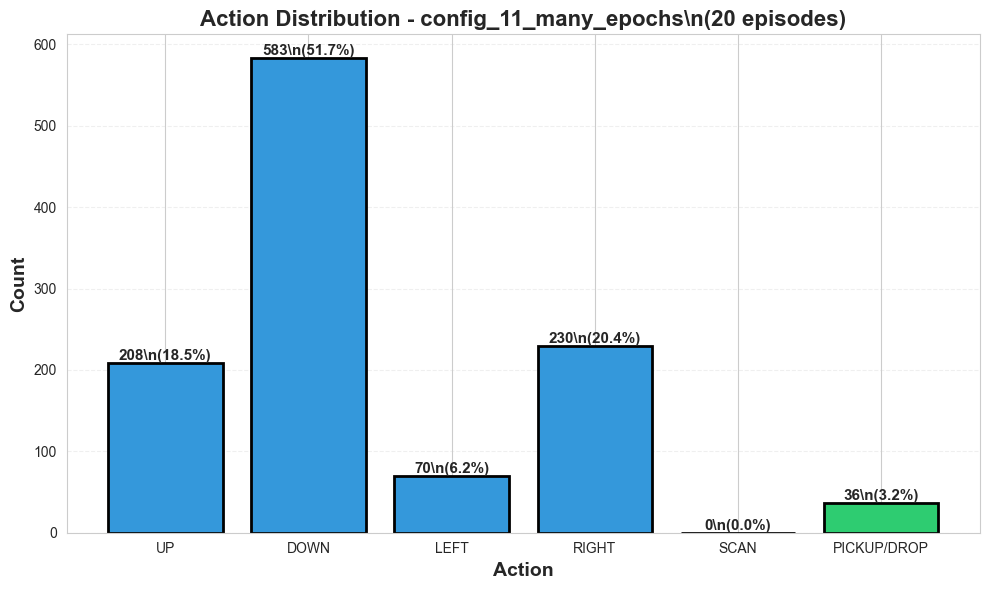


📊 Action distribution plot saved to:
   ../models/ppo/config_11_many_epochs/action_distribution.png


In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9.5: ACTION DISTRIBUTION ANALYSIS
# ═══════════════════════════════════════════════════════════════════════
"""
Analyze action usage to verify agent uses all actions (not just movement)
This proves the agent is not suffering from action space collapse
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("ACTION DISTRIBUTION ANALYSIS - BEST MODEL")
    print("="*80)
    
    # Load best model
    best_config = results_sorted[0]['config_name']
    model_path = f"../models/ppo/{best_config}/final_model"
    
    print(f"\nLoading model from: {model_path}")
    best_model = PPO.load(model_path)
    
    # Create test environment
    test_env = FireRescueEnv()
    
    # Action names
    action_names = {
        0: "UP",
        1: "DOWN", 
        2: "LEFT",
        3: "RIGHT",
        4: "SCAN",
        5: "PICKUP/DROP"
    }
    
    # Track actions across multiple episodes
    total_action_counts = {i: 0 for i in range(6)}
    total_steps = 0
    n_test_episodes = 20
    
    print(f"\nRunning {n_test_episodes} episodes to analyze action distribution...\n")
    
    for episode in range(n_test_episodes):
        obs, _ = test_env.reset()
        done = False
        
        while not done:
            action, _ = best_model.predict(obs, deterministic=True)
            action = int(action)  # Convert to int
            total_action_counts[action] += 1
            total_steps += 1
            
            obs, reward, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated
    
    test_env.close()
    
    # Display results
    print(f"{'='*60}")
    print(f"ACTION DISTRIBUTION ({n_test_episodes} episodes, {total_steps} total steps)")
    print(f"{'='*60}")
    
    for action_id, count in total_action_counts.items():
        pct = (count / total_steps * 100) if total_steps > 0 else 0
        bar = '█' * int(pct / 2)  # Visual bar
        print(f"  {action_names[action_id]:12s} (Action {action_id}): {count:4d} times ({pct:5.1f}%) {bar}")
    
    # Check for action space collapse
    scan_pct = (total_action_counts[4] / total_steps * 100) if total_steps > 0 else 0
    pickup_pct = (total_action_counts[5] / total_steps * 100) if total_steps > 0 else 0
    
    print(f"\n{'='*60}")
    print("ACTION SPACE HEALTH CHECK:")
    print(f"{'='*60}")
    
    if scan_pct > 0 and pickup_pct > 0:
        print("✅ PASS: Agent uses SCAN and PICKUP actions")
        print("✅ No action space collapse detected!")
    else:
        print("⚠️  WARNING: Agent may be avoiding some actions")
        if scan_pct == 0:
            print("   - SCAN action never used (0%)")
        if pickup_pct == 0:
            print("   - PICKUP/DROP action never used (0%)")
    
    # Create action distribution plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    actions = list(action_names.values())
    counts = [total_action_counts[i] for i in range(6)]
    colors_map = ['#3498db', '#3498db', '#3498db', '#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax.bar(actions, counts, color=colors_map, edgecolor='black', linewidth=2)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        pct = (count / total_steps * 100) if total_steps > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax.set_xlabel('Action', fontsize=14, fontweight='bold')
    ax.set_title(f'Action Distribution - {best_config}\\n({n_test_episodes} episodes)', 
                 fontsize=16, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'../models/ppo/{best_config}/action_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Action distribution plot saved to:")
    print(f"   ../models/ppo/{best_config}/action_distribution.png")
    print("="*80)
